# Brownian Bridge Construction

In [71]:
from scipy.stats import qmc
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [84]:
qmc.Sobol.reset

<function scipy.stats._qmc.Sobol.reset(self) -> 'Sobol'>

In [73]:
def BB(vis = True, *, time, samples, steps):
    from scipy.stats import qmc
    from scipy.stats import norm
    import numpy as np
    import matplotlib.pyplot as plt 
    
    T = time
    disc = steps 
    n_sims = samples 

    disc_log2 = round(np.log2(disc))
    n_sims_log2 = round(np.log2(n_sims))

    S = qmc.Sobol(d = disc , scramble = True)
    sobol = S.random_base2(n_sims_log2)
    invnorm_sobol = norm.ppf(sobol)
    Wt = np.empty([1, disc + 1]) # placeholder
    times = np.linspace(0, T, disc + 1) 

    for i in range(n_sims):
        sobol_ls = invnorm_sobol[i,:]
        WT = np.sqrt(T) * sobol_ls[0]
        ls = [(0,0), (T, WT)]
        n = 1 
        while n <= disc_log2 : 
            for i, j in enumerate(ls[:-1]):
                ls.append((0.5 * (j[0] + ls[i+1][0]), 0.5 * (j[1] + ls[i+1][1]) + np.sqrt(T / 2 ** (n + 1)) * sobol_ls[i+1]))

            n += 1
            ls = sorted(ls) 
        
        ls_arr = np.array(ls)
        Wt = np.vstack((Wt, ls_arr[:, 1]))
    
    Wt = Wt.T
    if vis:
        plt.plot(times, Wt)
        plt.xlabel('Time $T$')
        plt.ylabel('Brownian bridge paths')
        plt.title('{} Brownian bridge paths by Sobol\' Sequece'.format(samples))
        plt.show()
        return times, Wt
    else:
        return times, Wt

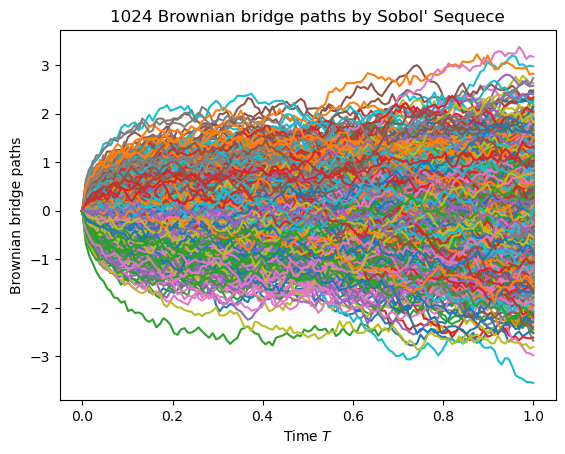

<function scipy.stats._qmc.Sobol.reset(self) -> 'Sobol'>

In [83]:
T = 1
sims = 2 ** 10 
disc = 2 ** 7
times, Wt = BB(time = T, samples = sims, steps = disc)
qmc.Sobol.reset

In [75]:
# construct a geometric Brownian motion using Brownian bridge
def GBB_Sobol(vis = True, *, S0, time, steps, samples, vol, rfr):
    times, Bt = BB(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples+1,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St
    else: 
        return times, St


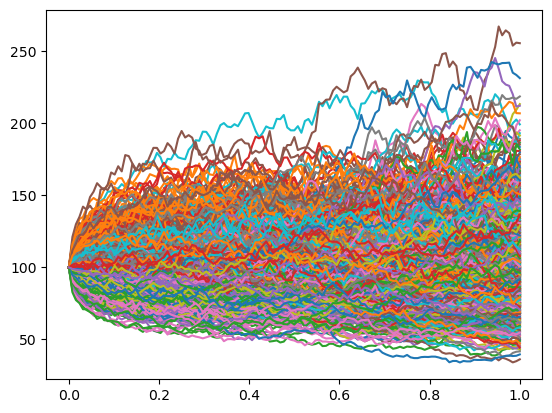

<function scipy.stats._qmc.Sobol.reset(self) -> 'Sobol'>

In [89]:
S0 = 100 # value of underlying asset at t = 0
r = 0 # risk-free rate
sigma = 0.3 # volitility 
K = 95

times, St = GBB_Sobol(time = T, samples = sims, steps = disc, S0 = S0, rfr = r, vol = sigma)
qmc.Sobol.reset

In [90]:
St1 = St[-1]
St1 = St1 - K 
C0_MC1 = St1[St1 > 0].sum() / St.shape[1] 
C0_MC1

14.267742067969246

In [86]:
def BS_option_call(*, maturity, S0, rfr, strike, time = 0, vol):
    import numpy as np 
    from scipy.stats import norm

    if time > strike:
        raise 'Time parameter is more than maturity parameter'
    
    d1 = (np.log(S0 / strike)  + (rfr + vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    d2 = (np.log(S0 / strike)  + (rfr - vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    return S0 * norm.cdf(d1) - np.exp(- rfr * (maturity - time)) * strike * norm.cdf(d2)

In [91]:
C0_BS1 = BS_option_call(maturity = T, S0 = S0, rfr = r, strike = K, vol = sigma)
C0_BS1

14.293649102263295

In [92]:
error = (np.abs(C0_MC1 - C0_BS1) / C0_BS1) * 100
print('Monte Carlo simulation option pricing: ', C0_MC1)
print('Analytical Black-Scholes option pricing: ', C0_BS1)  
print('Percentage error: ', error, '%')

Monte Carlo simulation option pricing:  14.267742067969246
Analytical Black-Scholes option pricing:  14.293649102263295
Percentage error:  0.18124856786883362 %


An amazing result using only 1024 samples as compared to 10,000 samples of the standard Monte Carlo Method. 